# EE353 ASSIGNMENT 4
#### PRIYANSH SINGH
#### 22b1856
#### [LINK TO THE EXPLANATORY VIDEO](https://drive.google.com/drive/folders/172HXrlvNaXwmgF3JjiKpkAfMhdhB2chy?usp=drive_link)

In [279]:
#data handling and basic math libraries
import pandas as pd #pandas for csv file reading and dataframe handling
import numpy as np #numpy for basic matrix computations

#plotting libraries
import matplotlib.pyplot as plt #for scatter and line plots of arrays
import seaborn as sns #for heatmaps

#scikit-learn - preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#scikit-learn - model selection
from sklearn.model_selection import GridSearchCV

#scikit-learn - clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
 
#scikit-learn - manifold
from sklearn.manifold import TSNE

#scikit-learn - dimensionality reduction
from sklearn.decomposition import PCA

#scikit-learn - metrics 
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

# Objective 1 - Data preprocessing

### Reading the dataset file

In [338]:
data = pd.read_csv("Customer-Data - 2.csv") #using pandas read csv to read the csv file

## 1.1 Data description [1]

- The dataset contains 18 features, giving insights on customer behaviour for 9000 customers for a duration of 6 months.

All the columns in the dataset comprise of continuous values.  
The behavioral features are as follows:
- 'BALANCE' - Balance amount left in the account
- 'BALANCE_FREQUENCY' -  How frequently the Balance is updated
- 'PURCHASES' - Amount of purchases made
- 'ONEOFF_PURCHASES' - Maximum purchase amount did in one-go
- 'INSTALLMENTS_PURCHASES' - Amount of purchase done in installment
- 'CASH_ADVANCE' - Cash in advance given by the user
- 'PURCHASES_FREQUENCY' - How frequently the Purchases are being made
- 'ONEOFF_PURCHASES_FREQUENCY' - How frequently Purchases are happening in one-go
- 'PURCHASES_INSTALLMENTS_FREQUENCY' - How frequently purchases in installments are being done
- 'CASH_ADVANCE_FREQUENCY' - How frequently the cash in advance being paid
- 'CASH_ADVANCE_TRX' - Number of Transactions made with “Cash in Advanced”
- 'PURCHASES_TRX' - Number of purchase transactions made
- 'CREDIT_LIMIT' - Limit of Credit Card for user
- 'PAYMENTS' - Amount of Payment done by the user
- 'MINIMUM_PAYMENTS' - Minimum amount of payments made by the user
- 'PRC_FULL_PAYMENT' - Percent of full payment paid by the user
- 'TENURE' - Tenure of credit card service for user

## 1.2 Missing values

- The data seems pretty much clean except the column 'MINIMUM_PAYMENTS', which has about 3% entries missing, which is not too much, apart from that, there's only one entry missing in the column 'CREDIT_LIMIT'.

In [350]:
# Removing the rows with missing entries
data_clean = data.dropna(axis = 0).reset_index().drop(['index', 'CUST_ID'], axis = 1)

## 1.3 Correlation heatmap

<Axes: >

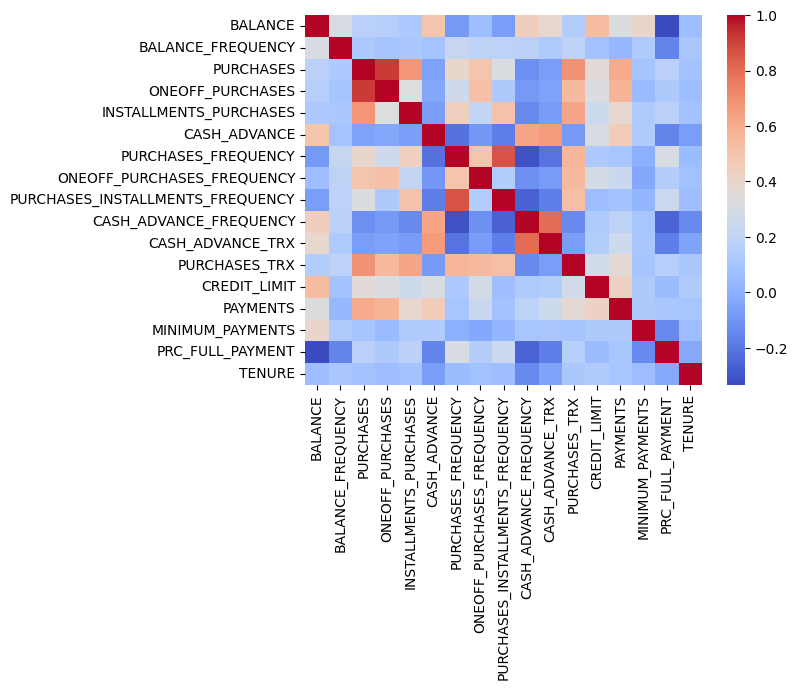

In [351]:
sns.heatmap(data_clean.corr(), cmap = 'coolwarm') #plotting the heatmap with the columm "CUST_ID" removed

- From the heatmap, and after testing on the actual models, it was found that dropping the columns 'ONEOFF_PURCHASES' and 'PURCHASES_INSTALLMENTS_FREQUENCY' led to improvements in the DB index and silhouette scores. 
- This can be explained from the correlation heatmap, as these two columns have high correlation with the columns 'PURCHASES' and 'PURCHASES_FREQUENCY'.

In [352]:
#Dropping the columns 'ONEOFF_PURCHASES' and 'PURCHASES_INSTALLMENTS_FREQUENCY'  
data_clean = data_clean.drop(['ONEOFF_PURCHASES', 'PURCHASES_INSTALLMENTS_FREQUENCY'], axis = 1)

## 1.4 Standardization

### Significantly high valued and skewed columns will have to be standardized, these include:
- 'BALANCE'
- 'PURCHASES'
- 'ONEOFF_PURCHASES'
- 'INSTALLMENTS_PURCHASES'
- 'CASH_ADVANCE'
- 'CREDIT_LIMIT'
- 'PAYMENTS'
- 'MINIMUM_PAYMENTS'


- Here I employ a log transformation on these columns with skewed distributions along with outliers. 
- The transformation is: x -> log(x + 1), where the 1 is added to avoid log(0) error.

In [ ]:
# List of columns to scale in a robust manner
columns_to_scale = [
    'BALANCE', 'PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 
    'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS'
]

#[2]
#[8]
data_clean[columns_to_scale] = data_clean[columns_to_scale].apply(lambda x: np.log(x + 1)) #applying the log transformation using a lambda function

# Create a Scaler instance
scaler = StandardScaler()

# Scale the data
data_clean_scaled = scaler.fit_transform(data_clean)

data_clean = pd.DataFrame(data_clean_scaled, columns=data_clean.columns)#converting the scaled data to a dataframe

# Objective 2 - Clustering

## 2a - K-means

In [354]:
X = data_clean #Dataset to be used for clustering

- Running the K means clustering algorithm for multiple values of k to determine the appropriate number of clusters 

In [ ]:
k_max = 2 #initialise the k for best scoe to 2
max_score = silhouette_score(X, KMeans(n_clusters = 2).fit(X).labels_) #initialize the best score
score_arr = [[2, max_score]] #array to store all scores
for k in range(3, 20): #iteratng for multiple values of k
    kmeans = KMeans(n_clusters = k).fit(X) #fit the k means model
    score = silhouette_score(X, kmeans.labels_) #computing the silhouette score

    if(score > max_score): #if score increases
      k_max = k #reset the k max
      max_score = score #reset the max score

    score_arr.append([k, score])#update the scores array

kmeans_final = KMeans(n_clusters = k_max).fit(X) #final k means model

- Getting the cluster centers for the final kmeans

- Using the percentile of each entry of the cluster centers to get their position with respect to all the features in the dataset

In [ ]:
#[7]
from scipy.stats import percentileofscore#to find the percentile of the cnetroid value

kmeans_cluster_centers = kmeans_final.cluster_centers_#cluster center

#Finding the rank of each entry of the cluster center in the dataframe columns
percentiles = [] #array to store all the percentiles

i = 0 #counter
for col in X.columns: #for all features
    percentiles_1 = percentileofscore(X[col], kmeans_cluster_centers[0][i], kind='rank') #percentiles for first cneter
    percentiles_2 = percentileofscore(X[col], kmeans_cluster_centers[1][i], kind='rank') #percentiles for second center
    percentiles.append([col, percentiles_1, percentiles_2]) #append them
    i += 1 #counter update

percentiles = pd.DataFrame(percentiles, columns = ['Feature', 'Center1', 'Center2']) # percentile dataframe
percentiles #print the percentile dataframe

,Feature,Center1,Center2
0,BALANCE,30.754979,68.017601
1,BALANCE_FREQUENCY,22.406207,29.018064
2,PURCHASES,63.142659,23.019917
3,INSTALLMENTS_PURCHASES,52.269569,43.399722
4,CASH_ADVANCE,51.308476,73.853636
5,PURCHASES_FREQUENCY,60.988884,35.861510
6,ONEOFF_PURCHASES_FREQUENCY,74.305234,59.865679
7,CASH_ADVANCE_FREQUENCY,51.308476,82.144511
8,CASH_ADVANCE_TRX,51.308476,85.896248
9,PURCHASES_TRX,79.064382,40.400648


## 2b - DBSCAN 

- Here, a Grid search to get two clusters will be done.

In [ ]:
#[5]
# Grid values for DBSCAN hyperparameters
threshold_values = np.arange(0.1, 0.3, 0.5, 0.6, 0.7, 0.9, 1.2, 1.7)  # epsilon values
min_samp_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # minimum number of samples for a core point

# Store the best parameters
best_params = []
found = False  # Flag to indicate if exactly 2 clusters are found

# Grid search for DBSCAN parameters
for min_samp in min_samp_values: #for al min samps
    for e in threshold_values: #for all thresholds
        dbscan = DBSCAN(eps=e, min_samples=min_samp).fit(X) # Fit the DBSCAN model
        
        labels = dbscan.labels_ # Extract cluster labels and count the number of clusters (excluding noise)
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise cluster (-1)

        # Check if exactly 2 clusters are formed
        if num_clusters == 2:
            best_params = [min_samp, e]
            found = True
            break  # Exit inner loop if condition is met
    if found:
        break  # Exit outer loop if condition is met

# Output the results
if found:
    print(f"Epsilon = {best_params[1]}")
    print(f"Min_samples = {best_params[0]}")
    # Train the final DBSCAN model with the identified parameters
    dbscan_final = DBSCAN(eps=best_params[1], min_samples=best_params[0]).fit(X)
else:
    print("No configuration found that produces exactly 2 clusters.")

Epsilon = 0.7
Min_samples = 6


## 2c - t-SNE for visualizing the clustering results

- Here, we try to get a 2 dimensional representation of the 15 dimensional data to be able to represent this in 2D space. 

In [327]:
X_reduced = TSNE(n_components=2).fit_transform(X) #Creating a 2D representation of the datapoints in X

### Visualizing the K means clusters

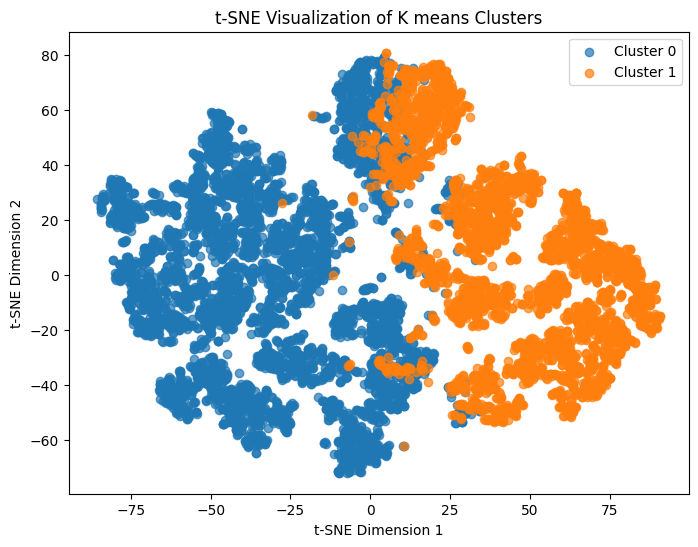

In [ ]:
#[4]
plt.figure(figsize=(8, 6)) #set figure size
unique_labels = set(kmeans_final.labels_) #unique labels
for label in unique_labels: #looping for unique labels
    mask = (kmeans_final.labels_ == label) #mask based on whether cluster 1 or 2
    plt.scatter(
        X_reduced[mask, 0], X_reduced[mask, 1],
        label=f'Cluster {label}' if label != -1 else 'Noise',
        alpha=0.7
    ) #scatter plot with labels for all clusters

plt.title('t-SNE Visualization of K means Clusters') #plot title
plt.xlabel('t-SNE Dimension 1') #plot x lable
plt.ylabel('t-SNE Dimension 2') #plot y label
plt.legend() #legend
plt.show() #show th plot

## 2d - Identifying the clusters as names

In [411]:
percentiles

,Feature,Center1,Center2
0,BALANCE,30.754979,68.017601
1,BALANCE_FREQUENCY,22.406207,29.018064
2,PURCHASES,63.142659,23.019917
3,INSTALLMENTS_PURCHASES,52.269569,43.399722
4,CASH_ADVANCE,51.308476,73.853636
5,PURCHASES_FREQUENCY,60.988884,35.861510
6,ONEOFF_PURCHASES_FREQUENCY,74.305234,59.865679
7,CASH_ADVANCE_FREQUENCY,51.308476,82.144511
8,CASH_ADVANCE_TRX,51.308476,85.896248
9,PURCHASES_TRX,79.064382,40.400648


### Looking at the percentiles of the entries of the cluster centers in the data, we can infer the behaviour of the two kinds of customers:  
1. Highly volatile accounts:  
  -- Tend to have lowaccount balance at any time  
  -- Tend to purchase a lot and also frequently  
  -- Tend to not pay cash in advance  
  -- Characterized by cluster 1

2. Less volatile, frugal spending:  
  -- Tend to have larger balance  
  -- Purchase only ocassionally  
  -- High tendnecy to pay in advance  
  -- Characterized by cluster 2

# Objective 3 - PCA

## 3a - Data Normalization and PCA

- Normalizing by standard scaling

In [ ]:
std_scaler = StandardScaler() #creating a scaler instance
data_normalized = std_scaler.fit_transform(data.dropna(axis = 0).reset_index().drop(['index', 'CUST_ID'], axis = 1)) #normalizing the data

- Training PCA

In [ ]:
pca_instance = PCA(n_components=data_normalized.shape[1]) #create a pca instance 
data_PCA = pca_instance.fit_transform(data_normalized) #fit the pca instance on the dataset

## 3b - PCA results

- Explained variance ratio

Text(0, 0.5, 'Explained variance ratio')

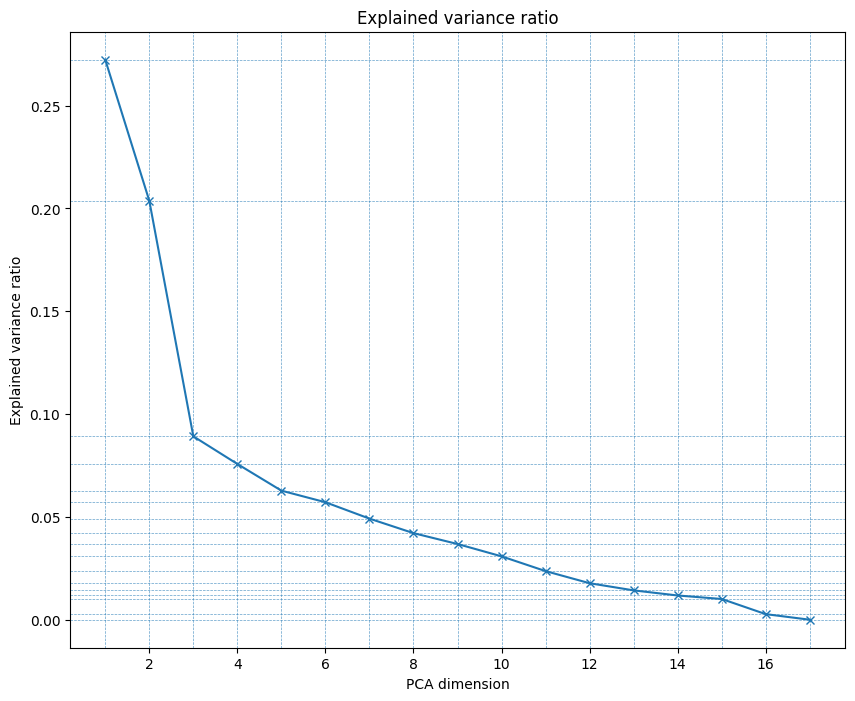

In [ ]:
plt.figure(figsize=(10,8)) #setting figure size
plt.plot((np.arange(data_PCA.shape[1]) + 1),  pca_instance.explained_variance_ratio_, marker = 'x') #line plot of explained variacnce

#[6]
# Add vertical grid lines for each x value
for x_val in (np.arange(data_PCA.shape[1]) + 1):
    plt.axvline(x=x_val, linestyle='--', linewidth=0.5, alpha=0.7)

# Add horizontal grid lines for each y value
for y_val in pca_instance.explained_variance_ratio_:
    plt.axhline(y=y_val, linestyle='--', linewidth=0.5, alpha=0.7)


plt.title("Explained variance ratio") #plot title
plt.xlabel('PCA dimension') #plot x label
plt.ylabel('Explained variance ratio') #plot y axis label


## 3c - Data Reconstruction

- Function for complete reconstruction of the reduced dimension data

In [ ]:
def reconstruct(data_pca_reduced, PCA_instance, scaler, original_dataframe): #function to reconstruct
    #[7]
    data_reconstructed_scaled = PCA_instance.inverse_transform(data_pca_reduced) #take the inverse PCA transform
    data_reconstructed = scaler.inverse_transform(data_reconstructed_scaled) #take the inverse of scaling
    df_reconstructed = pd.DataFrame(data_reconstructed, columns=original_dataframe.columns) #create a dataframe

    return df_reconstructed #function return


- Iteratively doing PCA with reduced number of dimensions and computing the MSE everytime

In [ ]:
MSE_arr = [] #array to hold MSE values

std_scaler = StandardScaler() #scaler instance
data_clean_3 = data.dropna(axis = 0).reset_index().drop(['index', 'CUST_ID'], axis = 1) #data scaling
data_normalized = std_scaler.fit_transform(data_clean_3) #fitting the scaler on the data

for num_components in range(1, data_normalized.shape[1]): #looping for the number of columns
    pca_instance = PCA(n_components = num_components) #creating a PCA instance
    data_PCA = pca_instance.fit_transform(data_normalized) #fitting PCA on the normalized data  
    data_reconstructed = reconstruct(data_PCA, pca_instance, std_scaler, data_clean_3) #reconstructing the data
    MSE_arr.append([num_components, mean_squared_error(data_clean_3, data_reconstructed)]) #calclulate MSE and append

MSE_arr = np.array(MSE_arr) #convert to numpy array

Text(0, 0.5, 'MSE')

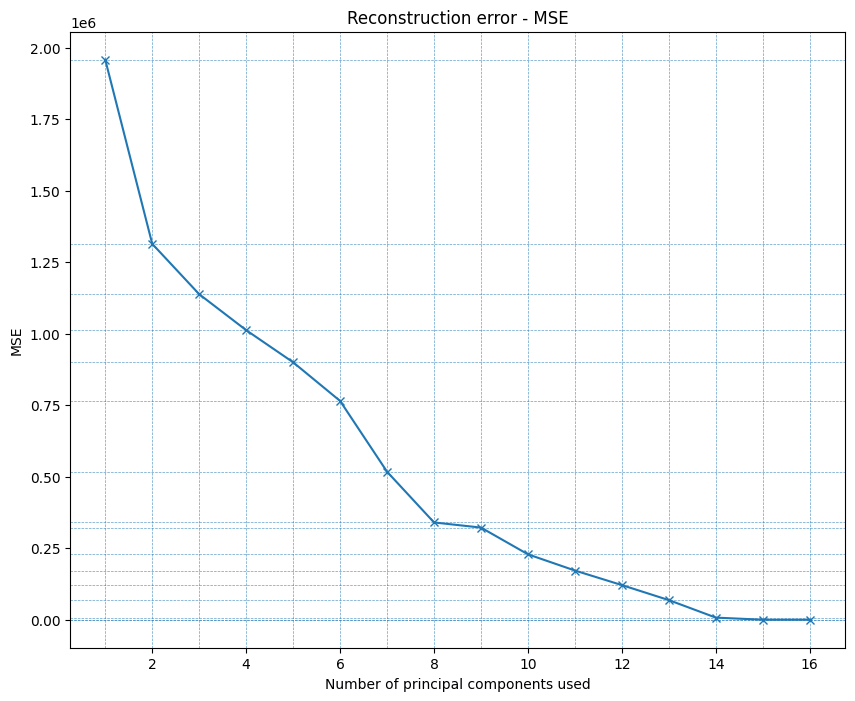

In [ ]:
plt.figure(figsize=(10,8)) #figure size
plt.plot(MSE_arr[:,0], MSE_arr[:,1], marker = 'x') #line plot of MSEs

#[6]
# Add vertical grid lines for each x value
for x_val in (MSE_arr[:,0]):
    plt.axvline(x=x_val, linestyle='--', linewidth=0.5, alpha=0.7)

# Add horizontal grid lines for each y value
for y_val in MSE_arr[:,1]:
    plt.axhline(y=y_val, linestyle='--', linewidth=0.5, alpha=0.7)


plt.title("Reconstruction error - MSE") #plot title
plt.xlabel('Number of principal components used') #plot x axis label
plt.ylabel('MSE') #plot y axs label


### Observation:
- As expected, the reconstruction error decreases monotonically with an increasing number of principal components used, this is because of the increase in the explained variance as the number of top components used increases.
- Note: It would be incorrect to infer the MSE as high looking at the 10^6 order, this high order of the MSE is because of the fact that MSE is an un-normalized metric and hence shoots up for a large dataset. 
- It would've been better to use the normalized MSE to compare the two huge dataframes, but as the problem statement mentions so, MSE has been used. 

# References:  
[1]: Description of the dataset taken from this [kaggle page](https://www.kaggle.com/datasets/alirezachahardoli/customer-data-clustring/data)    
[2]: ChatGPT prompt: How to scale data with outliers. 
[3]: Sklearn documentation for [RobustScaler](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.RobustScaler.html) for the mathematical description.  
[4]: ChatGPT prompt: How to visualize t-SNE embeddings for a clustering model.  
[5]: ChatGPT prompt: Help with grid search for dbscan to get two clusters.  
[6]: ChatGPT prompt: Add gridlines to a line plot for all datapoints in the array.  
[7]: ChatGPT prompt: Find percentile fo a number in the various columns of a dataframe.
[8]: ChatGPT prompt: Apply a log transformation on a dataframe also avoiding the log(0) error